In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2
import os

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d shayanfazeli/heartbeat

 90% 89.0M/98.8M [00:01<00:00, 42.5MB/s]
100% 98.8M/98.8M [00:01<00:00, 58.6MB/s]


In [5]:
import zipfile
zf = "/content/heartbeat.zip"
target_dir = "/content/dataset/mitbih-database"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import resample
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random

In [7]:
train = pd.read_csv('/content/dataset/mitbih-database/mitbih_train.csv',header=None).astype(np.float32)
test = pd.read_csv('/content/dataset/mitbih-database/mitbih_test.csv',header=None).astype(np.float32)

In [8]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,0.052632,0.140351,0.119298,0.091228,0.140351,0.161404,0.105263,0.143860,0.143860,0.129825,0.147368,0.157895,0.164912,0.168421,0.154386,0.175439,0.164912,0.154386,0.182456,0.192982,0.196491,0.207018,0.217544,0.217544,0.256140,0.284211,0.294737,0.301754,0.301754,0.322807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,0.078333,0.183333,0.275000,0.315000,0.361667,0.430000,0.481667,0.526667,0.543333,0.563333,0.581667,0.588333,0.600000,0.603333,0.613333,0.6216

In [9]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890356,0.758160,0.423974,0.219104,0.201128,0.210400,0.205808,0.201773,0.198692,0.196757,0.198779,0.203551,0.208776,0.212885,0.218393,0.224967,0.231379,0.237125,0.242582,0.247923,0.253751,0.259748,0.266245,0.272733,0.279354,0.285588,0.291808,0.297672,0.303384,0.308793,0.313893,0.318457,0.322086,0.324891,0.326734,0.327816,0.327930,0.326746,0.324325,0.320536,...,0.030729,0.029582,0.028531,0.027573,0.026875,0.025771,0.024823,0.023932,0.023060,0.022458,0.021809,0.021245,0.020623,0.020026,0.019534,0.019053,0.018592,0.017664,0.016740,0.015722,0.014402,0.013024,0.011625,0.010262,0.008929,0.008056,0.007278,0.006531,0.005981,0.005479,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240888,0.221814,0.227304,0.206878,0.177056,0.171909,0.178480,0.177242,0.171778,0.168357,0.171796,0.176496,0.180276,0.184101,0.186961,0.190001,0.193898,0.198464,0.202855,0.207166,0.211186,0.214820,0.218448,0.221486,0.224031,0.225848,0.227133,0.227828,0.228436,0.228871,0.228760,0.228392,0.227472,0.226179,0.224658,0.223108,0.221350,0.219258,0.216883,0.214167,...,0.116490,0.114428,0.112680,0.111051,0.110542,0.108570,0.106472,0.104562,0.102671,0.101389,0.100239,0.099363,0.098335,0.096661,0.095734,0.095383,0.095070,0.092874,0.091131,0.088560,0.084640,0.079984,0.075278,0.069872,0.063992,0.060067,0.056399,0.052856,0.050005,0.046697,0.044163,0.042087,0.040523,0.038648,0.037200,0.036258,0.034781,0.032867,0.031921,1.143108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,0.070543,0.069182,0.068293,0.067744,0.070175,0.072993,0.074803,0.075972,0.076923,0.077872,0.079442,0.081911,0.085938,0.090032,0.094595,0.098901,0.103960,0.109348,0.114754,0.120730,0.127946,0.135962,0.144295,0.151852,0.157895,0.161035,0.161133,0.159383,0.157343,0.155388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Count in each label: 
0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


<BarContainer object of 5 artists>

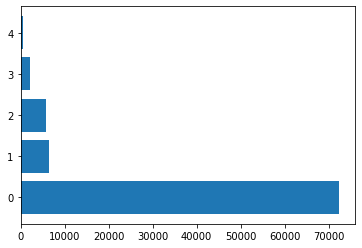

In [10]:
# The classes

label_names = ['Non-ecotic beats (normal beat)', 'Supraventricular ectopic beats', 'Ventricular ectopic beats', 'Fusion beats', 'Unknown beats']

labels = train[187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

plt.barh(list(set(labels)), list(labels.value_counts()))

Count in each label: 
0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


<BarContainer object of 5 artists>

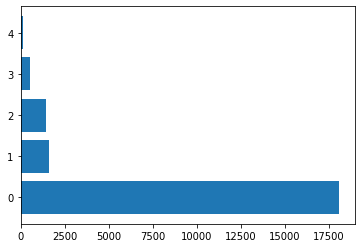

In [11]:
# The classes

label_names = ['Non-ecotic beats (normal beat)', 'Supraventricular ectopic beats', 'Ventricular ectopic beats', 'Fusion beats', 'Unknown beats']

labels = test[187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

plt.barh(list(set(labels)), list(labels.value_counts()))

In [12]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,0.030992,0.028926,0.035124,0.026860,0.039256,0.035124,0.043388,0.047521,0.053719,0.053719,0.070248,0.072314,0.084711,0.097107,0.121901,0.132231,0.169421,0.196281,0.214876,0.235537,0.254132,0.264463,0.285124,0.272727,0.266529,0.239669,0.214876,0.173554,0.157025,0.123967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,0.304029,0.336996,0.377289,0.391941,0.439560,0.446886,0.457875,0.479853,0.512821,0.534799,0.586081,0.586081,0.604396,0.633700,0.615385,0.582418,0.564103,0.520147,0.490842,0.490842,0.468864,0.454212,0.450549,0.465201,0.450549,0.432234,0.424908,0.410256,0.391941,0.369963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,0.106195,0.141593,0.128319,0.150442,0.132743,0.150442,0.132743,0.150442,0.123894,0.163717,0.137168,0.141593,0.132743,0.150442,0.128319,0.146018,0.119469,0.123894,0.101770,0.092920,0.070796,0.079646,0.066372,0.070796,0.079646,0.092920,0.088496,0.084071,0.079646,0.088496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,0.102083,0.122917,0.150000,0.168750,0.172917,0.170833,0.168750,0.164583,0.156250,0.152083,0.147917,0.147917,0.145833,0.145833,0.141667,0.141667,0.147917,0.158333,0.168750,0.179167,0.191667,0.206250,0.220833,0.239583,0.258333,0.275000,0.287500,0.308333,0.320833,0.331250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,0.080537,0.104027,0.093960,0.117450,0.097315,0.134228,0.124161,0.161074,0.171141,0.194631,0.204698,0.261745,0.275168,0.332215,0.345638,0.395973,0.406040,0.456376,0.446309,0.446309,0.399329,0.369128,0.308725,0.295302,0.265101,0.271812,0.258389,0.268456,0.261745,0.281879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,0.075862,0.032184,0.000000,0.012644,0.119540,0.243678,0.310345,0.367816,0.412644,0.434483,0.502299,0.533333,0.563218,0.627586,0.671264,0.685057,0.679310,0.679310,0.677011,0.681609,0.690805,0.700000,0.713793,0.736782,0.752874,0.771264,0.783908,0.800000,0.806897,0.813793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,0.289985,0.376682,0.412556,0.452915,0.529148,0.582960,0.641256,0.662182,0.678625,0.684604,0.695067,0.699552,0.710015,0.704036,0.726457,0.7354

In [13]:
# Separating the test dataframe into 5 individual ones based on class labels, and sampling 5000 from each.

test_lbl0 = resample(test[test[187]==0], replace=True, n_samples=5000, random_state=113)
test_lbl1 = resample(test[test[187]==1], replace=True, n_samples=5000, random_state=113)
test_lbl2 = resample(test[test[187]==2], replace=True, n_samples=5000, random_state=113)
test_lbl3 = resample(test[test[187]==3], replace=True, n_samples=5000, random_state=113)
test_lbl4 = resample(test[test[187]==4], replace=True, n_samples=5000, random_state=113)

In [14]:
# Concatenate the 5 dataframes into 1

test = pd.concat([test_lbl0, test_lbl1, test_lbl2, test_lbl3, test_lbl4]).astype(np.float32)

labels = test[187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

Count in each label: 
4    5000
3    5000
2    5000
1    5000
0    5000
Name: 187, dtype: int64


In [15]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
14501,0.996532,0.842775,0.398844,0.000000,0.187283,0.233526,0.171098,0.163006,0.174566,0.178035,0.174566,0.179191,0.182659,0.189595,0.191908,0.193064,0.202312,0.218497,0.216185,0.225434,0.239306,0.254335,0.263584,0.278613,0.301734,0.323699,0.331792,0.349133,0.359538,0.365318,0.354913,0.339884,0.320231,0.290173,0.253179,0.221965,0.206936,0.201156,0.183815,0.180347,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4828,0.961165,0.936893,0.762136,0.524272,0.310680,0.169903,0.087379,0.101942,0.135922,0.116505,0.097087,0.135922,0.155340,0.150485,0.135922,0.165049,0.179612,0.145631,0.169903,0.184466,0.189320,0.189320,0.189320,0.223301,0.228155,0.208738,0.213592,0.237864,0.262136,0.237864,0.242718,0.257282,0.286408,0.262136,0.262136,0.252427,0.252427,0.233010,0.208738,0.194175,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16236,0.000000,0.074286,0.154286,0.354286,0.480000,0.582857,0.702857,0.680000,0.708571,0.725714,0.742857,0.742857,0.731429,0.720000,0.737143,0.760000,0.737143,0.765714,0.742857,0.754286,0.782857,0.782857,0.811429,0.817143,0.817143,0.834286,0.857143,0.851429,0.885714,0.862857,0.902857,0.914286,0.925714,0.897143,0.897143,0.925714,0.885714,0.868571,0.868571,0.811429,...,0.782857,0.788571,0.805714,0.811429,0.805714,0.805714,0.845714,0.834286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11010,1.000000,0.967871,0.570281,0.273092,0.246988,0.216867,0.204819,0.158635,0.160643,0.112450,0.092369,0.072289,0.078313,0.066265,0.070281,0.058233,0.070281,0.048193,0.068273,0.054217,0.054217,0.040161,0.046185,0.028112,0.026104,0.020080,0.030120,0.014056,0.024096,0.000000,0.012048,0.024096,0.036145,0.050201,0.088353,0.098394,0.130522,0.114458,0.146586,0.146586,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2710,0.899142,0.864807,0.371245,0.004292,0.006438,0.057940,0.060086,0.066524,0.064378,0.057940,0.049356,0.057940,0.051502,0.038627,0.038627,0.042918,0.032189,0.034335,0.023605,0.027897,0.023605,0.008584,0.000000,0.002146,0.008584,0.012876,0.015021,0.032189,0.047210,0.053648,0.072961,0.098712,0.124464,0.130901,0.139485,0.150215,0.150215,0.143777,0.141631,0.139485,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20690,0.935006,0.880274,0.802737,0.724059,0.620296,0.510832,0.354618,0.236032,0.139111,0.115165,0.102623,0.060433,0.019384,0.023945,0.104903,0.231471,0.298746,0.343215,0.366021,0.389966,0.429875,0.482326,0.527936,0.586089,0.627138,0.665906,0.677309,0.694413,0.702395,0.729761,0.741163,0.763968,0.781072,0.806157,0.822121,0.849487,0.864310,0.876853,0.873432,0.881414,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [16]:
# Separating the train dataframe into 5 individual ones based on class labels, and sampling 20000 from each.

train_lbl0 = resample(train[train[187]==0], replace=True, n_samples=20000, random_state=113)
train_lbl1 = resample(train[train[187]==1], replace=True, n_samples=20000, random_state=113)
train_lbl2 = resample(train[train[187]==2], replace=True, n_samples=20000, random_state=113)
train_lbl3 = resample(train[train[187]==3], replace=True, n_samples=20000, random_state=113)
train_lbl4 = resample(train[train[187]==4], replace=True, n_samples=20000, random_state=113)

In [17]:
# Concatenate the 5 dataframes into 1

train = pd.concat([train_lbl0, train_lbl1, train_lbl2, train_lbl3, train_lbl4]).astype(np.float32)

labels = train[187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

Count in each label: 
4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


In [18]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
30282,0.841743,0.706422,0.363532,0.310780,0.387615,0.355505,0.333716,0.333716,0.329128,0.325688,0.329128,0.329128,0.322248,0.323395,0.326835,0.326835,0.323395,0.323395,0.332569,0.332569,0.327982,0.334862,0.341743,0.347477,0.347477,0.356651,0.369266,0.377294,0.386468,0.397936,0.417431,0.430046,0.434633,0.443807,0.458716,0.462156,0.457569,0.444954,0.435780,0.415138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16236,0.944321,0.683742,0.040089,0.118040,0.131403,0.133630,0.118040,0.126949,0.129176,0.144766,0.265033,0.169265,0.167038,0.193764,0.200445,0.207127,0.191537,0.216036,0.200445,0.204900,0.209354,0.265033,0.287305,0.340757,0.336303,0.365256,0.376392,0.356347,0.314031,0.302895,0.236080,0.189310,0.167038,0.193764,0.129176,0.111359,0.093541,0.104677,0.086860,0.091314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2710,0.876122,0.971275,0.558348,0.143627,0.066427,0.025135,0.003591,0.001795,0.039497,0.134650,0.298025,0.396768,0.418312,0.430880,0.439856,0.430880,0.439856,0.441652,0.423698,0.420108,0.411131,0.403950,0.393178,0.378815,0.369838,0.368043,0.351885,0.344704,0.350090,0.348294,0.341113,0.357271,0.378815,0.380610,0.394973,0.412926,0.445242,0.457810,0.459605,0.464991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66327,1.000000,0.757322,0.418410,0.037657,0.016736,0.142259,0.246862,0.251046,0.251046,0.263598,0.276151,0.280335,0.259414,0.267782,0.267782,0.255230,0.251046,0.251046,0.255230,0.242678,0.234310,0.225941,0.230126,0.230126,0.217573,0.196653,0.200837,0.196653,0.188285,0.184100,0.217573,0.217573,0.225941,0.234310,0.271967,0.297071,0.313808,0.368201,0.435146,0.472803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47344,1.000000,0.763699,0.476027,0.363014,0.304795,0.277397,0.263699,0.267123,0.260274,0.260274,0.250000,0.250000,0.243151,0.222603,0.219178,0.212329,0.198630,0.160959,0.154110,0.154110,0.164384,0.147260,0.178082,0.198630,0.195205,0.164384,0.154110,0.130137,0.126712,0.102740,0.123288,0.106164,0.130137,0.130137,0.140411,0.136986,0.140411,0.123288,0.150685,0.136986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83550,0.816479,0.516854,0.554307,0.546816,0.569288,0.535581,0.513109,0.419476,0.303371,0.157303,0.000000,0.022472,0.056180,0.033708,0.067416,0.138577,0.157303,0.146067,0.142322,0.164794,0.176030,0.164794,0.176030,0.149813,0.134831,0.108614,0.101124,0.082397,0.093633,0.063670,0.074906,0.052434,0.074906,0.067416,0.093633,0.104869,0.142322,0.153558,0.194757,0.213483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
81987,1.000000,0.990566,0.625786,0.383648,0.169811,0.113208,0.091195,0.110063,0.113208,0.116352,0.106918,0.088050,0.091195,0.094340,0.088050,0.088050,0.075472,0.069182,0.062893,0.059748,0.053459,0.044025,0.034591,0.034

Text(0.5, 1.0, 'Non-ecotic beats (normal beat)')

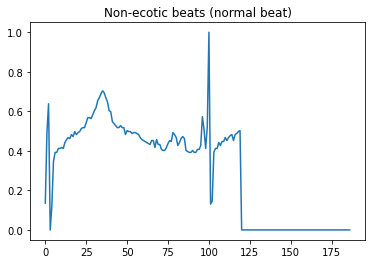

In [19]:
plt.plot(np.array(train_lbl0.sample(1))[0, :187])
plt.title(label_names[0])

Text(0.5, 1.0, 'Supraventricular ectopic beats')

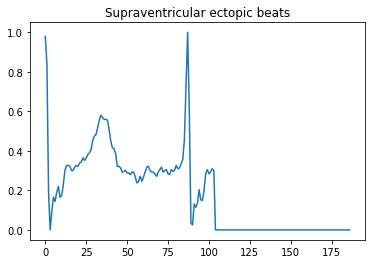

In [20]:
plt.plot(np.array(train_lbl1.sample(1))[0, :187])
plt.title(label_names[1])

Text(0.5, 1.0, 'Ventricular ectopic beats')

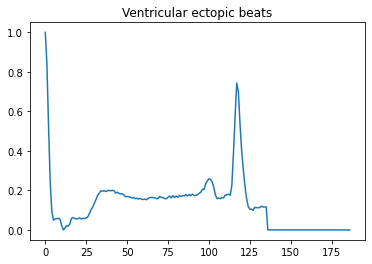

In [21]:
plt.plot(np.array(train_lbl2.sample(1))[0, :187])
plt.title(label_names[2])

Text(0.5, 1.0, 'Fusion beats')

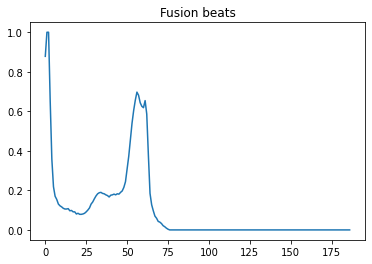

In [22]:
plt.plot(np.array(train_lbl3.sample(1))[0, :187])
plt.title(label_names[3])

Text(0.5, 1.0, 'Unknown beats')

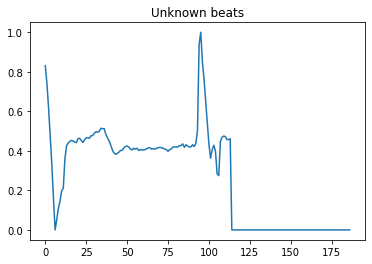

In [23]:
plt.plot(np.array(train_lbl4.sample(1))[0, :187])
plt.title(label_names[4])

In [24]:
# train.sample(1).values[0]

In [25]:
train.sample(1)[187]

82415    4.0
Name: 187, dtype: float32

In [26]:
import gc

In [27]:
gc.collect()

200

In [28]:
  # f = open('/content/drive/MyDrive/mitbih/labels/labels.txt','a')
  # f.write(str(train.iloc[i,187]))
  # f.write('\n')

In [115]:
!cp drive/MyDrive/mitbih.zip .
!unzip mitbih.zip

Archive:  mitbih.zip
replace mitbih/fb/79811.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [137]:
!cp drive/MyDrive/mitbih_test.zip .
!unzip mitbih_test.zip

Archive:  mitbih_test.zip
replace mitbih/test/fb/17827.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [29]:
import zipfile
zf = "/content/drive/MyDrive/mitbih.zip"
target_dir = "/content/train"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [30]:
import zipfile
zf = "/content/drive/MyDrive/mitbih_test.zip"
target_dir = "/content/test"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [127]:
# DONT RUN BELOW CELLS TO GENERATE IF DATASET COPIED FROM DRIVE IN ABOVE CELLS
from tqdm.notebook import tqdm

import concurrent.futures
import os

In [128]:
datadir = "/content/mitbih/test/"

In [129]:
!mkdir -p $datadir/normal
!mkdir $datadir/sve
!mkdir $datadir/ve
!mkdir $datadir/fb
!mkdir $datadir/ub

In [130]:
# replaced the slower if statements
lbl_dict = {0.0: 'normal/',
            1.0: 'sve/',
            2.0: 've/',
            3.0: 'fb/',
            4.0: 'ub/'}

In [131]:
# function to call in parallel
def save_sample(sample, save_path):
    plt.figure(figsize=[1,1])
    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.plot(sample)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

In [132]:
test.shape[0]

25000

In [133]:
# Multiprocessing call
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    for i in tqdm(range(test.shape[0])):
        sample = test.iloc[i,:187]
        save_path = datadir+lbl_dict[test.iloc[i,187]]+str(i)+'.jpg'
        if not os.path.exists(save_path):
            executor.submit(save_sample, sample, save_path)

In [134]:
!zip -q -r mitbih_test.zip mitbih/test/

In [135]:
!mv mitbih_test.zip drive/MyDrive/

In [ ]:
# DONT RUN BELOW CELLS TO GENERATE IF DATASET COPIED FROM DRIVE IN ABOVE CELLS
from tqdm.notebook import tqdm

In [ ]:
datadir = "/content/mitbih/"

In [ ]:
# !rm -rf $datadir

In [ ]:
!mkdir -p $datadir/normal
!mkdir $datadir/sve
!mkdir $datadir/ve
!mkdir $datadir/fb
!mkdir $datadir/ub

In [ ]:
import concurrent.futures
import os

In [ ]:
# replaced the slower if statements
lbl_dict = {0.0: 'normal/',
            1.0: 'sve/',
            2.0: 've/',
            3.0: 'fb/',
            4.0: 'ub/'}
# function to call in parallel
def save_sample(sample, save_path):
    plt.figure(figsize=[1,1])
    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.plot(sample)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

In [ ]:
# Multiprocessing call
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    for i in tqdm(range(train.shape[0])):
        sample = train.iloc[i,:187]
        save_path = datadir+lbl_dict[train.iloc[i,187]]+str(i)+'.jpg'
        if not os.path.exists(save_path):
            executor.submit(save_sample, sample, save_path)

In [ ]:
!zip -q -r mitbih.zip mitbih/

In [ ]:
!mv mitbih.zip drive/MyDrive/

In [ ]:
gc.collect()

646

In [ ]:
!ls '/content/mitbih/'

fb  normal  sve  ub  ve


In [31]:
batch_size = 512

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory('/content/train/mitbih',target_size=(64,64),batch_size=batch_size,
                                                    class_mode='categorical',color_mode='grayscale')

Found 100000 images belonging to 5 classes.


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = train_datagen.flow_from_directory('/content/test/mitbih/test',target_size=(64,64),batch_size=batch_size,
                                                    class_mode='categorical',color_mode='grayscale',shuffle=False)

Found 25000 images belonging to 5 classes.


In [34]:
model = Sequential()

model.add(Conv2D(64,3,input_shape=(64,64,1),kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(64,3,kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128,3,kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(128,3,kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256,3,kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(Conv2D(256,3,kernel_initializer='glorot_uniform'))
model.add(keras.layers.ELU())
model.add(BatchNormalization())

model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(2048))

model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Dropout(0.2))

model.add(Dense(activation='softmax',units=5))

In [35]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
elu (ELU)                    (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
elu_1 (ELU)                  (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0

In [37]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=25)

Epoch 1/25
195/195 [==============================] - 52s 173ms/step - loss: 1.0359 - accuracy: 0.8374
Epoch 2/25
195/195 [==============================] - 32s 166ms/step - loss: 0.0660 - accuracy: 0.9780
Epoch 3/25
195/195 [==============================] - 33s 167ms/step - loss: 0.0343 - accuracy: 0.9886
Epoch 4/25
195/195 [==============================] - 33s 166ms/step - loss: 0.0180 - accuracy: 0.9945
Epoch 5/25
195/195 [==============================] - 33s 167ms/step - loss: 0.0138 - accuracy: 0.9955
Epoch 6/25
195/195 [==============================] - 33s 167ms/step - loss: 0.0138 - accuracy: 0.9957
Epoch 7/25
195/195 [==============================] - 33s 166ms/step - loss: 0.0077 - accuracy: 0.9977
Epoch 8/25
195/195 [==============================] - 33s 167ms/step - loss: 0.0062 - accuracy: 0.9981
Epoch 9/25
195/195 [==============================] - 33s 167ms/step - loss: 0.0101 - accuracy: 0.9968
Epoch 10/25
195/195 [==============================] - 33s 167ms/step - l

In [38]:
test_accu = model.evaluate(test_generator)
print('The testing accuracy is - ',test_accu[1]*100,'%')

49/49 [==============================] - 9s 169ms/step - loss: 0.8975 - accuracy: 0.8934
The testing accuracy is -  89.33600187301636 %


In [39]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss, precision_score, recall_score

y_bar = np.round(model.predict(test_generator))
y_act = keras.utils.to_categorical(test_generator.labels)

##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act,average='macro'))
##Precision score
print("Precision: ",precision_score(y_bar,y_act,average='macro'))
##Recall score
print("Recall: ",recall_score(y_bar,y_act,average='macro'))

Accuracy:  0.89308
F1 score:  0.8957204216200563
Precision:  0.89308
Recall:  0.9169287564852715
